In [7]:
# import modules
import sys
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
import os
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from functions_EDX import *
from VCA import *

import pacmap
from annoy import AnnoyIndex
import random
from ipywidgets import interact, widgets, Button, Output
import distinctipy
import tifffile as tf

### Auxilliary functions

In [34]:
def get_points(local_maxi,Grid,embeddings):
    local_max_x = []
    local_max_y = []
    
    for i in range(0,len(local_maxi)):
        NewValue_X = (((local_maxi[i][0] ) * (xmax - xmin)) / (Grid - 0)) + xmin
        NewValue_Y = (((local_maxi[i][1] - 0) * (ymax - ymin)) / (Grid - 0)) + ymin
        local_max_x.append(NewValue_X)
        local_max_y.append(NewValue_Y)
    
    x = [x for x in zip(local_max_x,local_max_y)]
    
    min_max = 1*(1/Grid) # determines bounding box size
    points = len(x)
    centroid = [] 
    F = []           
    
    for i in range(0,points):
        #set bounding square 
        Minx = x[i][0] - min_max
        Maxx = x[i][0] + min_max
        Miny = x[i][1] - min_max
        Maxy = x[i][1] + min_max
        
        #select points
        z3 = [0 if j == 0 else j for j in [j if j <= Maxx else 0 for j in [j if j >= Minx else 0 for j in embeddings[:,0]]]]
        zz3 = [0 if j == 0 else j for j in [j if j <= Maxy else 0 for j in [j if j >= Miny else 0 for j in embeddings[:,1]]]]
        f = [i for i, e in enumerate([x*y for x,y in zip(z3,zz3)]) if e != 0]
        d = embeddings[f]
        F.append(f)
        centroid.append(d)
    return F,centroid

### Load a  single tile hyperspectral dataset (preprocessed)

In [8]:
# choose a directory (from the multi-tile map)
npz_dir = '/Volumes/Microscopy3/EDX_data/Identify/main_mosaic_6by5/Spectrum2D_extendedGauss1_3_5/'
# or 'path/to/NPZdirectory' 
file_names = os.listdir(npz_dir)
file_names = [name for name in file_names if name.endswith('npz')]

# chooe the index of the dataset within the directory
file_idx = 4 # same tile used in Figure 4, containing left overlap

# load data
file_path = os.path.join(npz_dir,file_names[file_idx])
spectrum_2D = np.load(file_path)['spectrum_2D'][:,:250] # taking the original spectrum only (not the Gauss blurred)

### Load the HAADF image (normalized)

In [12]:
HomePath = '/Users/AJ/Desktop/CellFigures/raw_material/Figure 4/PeterMasks' #r'D:\Projects\IDENTIFY\Data\Figure 3'
haadf_folder = os.path.join(HomePath, 'HAADFs')
haadf = tf.imread(os.path.join(haadf_folder, "Tile_%02d.tiff" % file_idx))
xray_energies = np.load('/Volumes/Microscopy3/EDX_data/Identify/main_mosaic_6by5/NPZ/20230512 2210 HAADF_20.npz')['xray_energies'][96:]
xray_energies = rebin_energies(xray_energies,250)

### Element energy lines

In [15]:
import exspy as xs

# define elements to plot, their x-ray lines and find the respective energy (in keV)
xray_lines = [['C', 'Ka'],['N', 'Ka'],['O', 'Ka'],['P', 'Ka'],['S', 'Ka'],['Cl', 'Ka'],['Ca', 'Ka'],['Cu', 'Ka'],
              ['Cu', 'La'],['Al', 'Ka'],['Fe', 'Ka'],['Fe', 'La'],['Os', 'Ma'],['Os', 'La'],['Nd','La']]

for idx, xray in enumerate(xray_lines):
    xray_lines[idx].append(xs.misc.elements.elements[xray[0]]['Atomic_properties']['Xray_lines'][xray[1]]['energy (keV)'])


xticks = []
for xray in xray_lines:
    xticks.append(np.argmin(np.abs(xray_energies-xray[2])))

for i in range(len(xticks)):
    print("%s %s:  Index %02d" % (xray_lines[i][0],xray_lines[i][1],xticks[i]))

C Ka:  Index 03
N Ka:  Index 04
O Ka:  Index 06
P Ka:  Index 25
S Ka:  Index 28
Cl Ka:  Index 32
Ca Ka:  Index 46
Cu Ka:  Index 100
Cu La:  Index 11
Al Ka:  Index 18
Fe Ka:  Index 80
Fe La:  Index 08
Os Ma:  Index 23
Os La:  Index 111
Nd La:  Index 65


### Display HAADF, NPS, and element maps showing the overlap effect

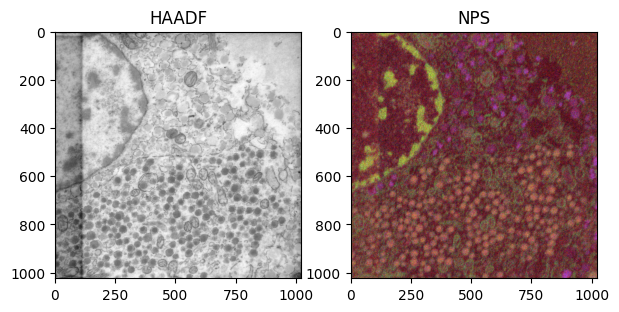

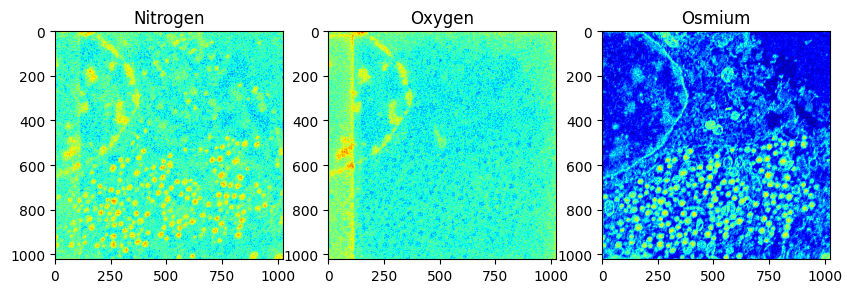

In [21]:
spectrum = spectrum_2D.reshape((1024,1024,250))
rgb = cv.merge([normalize8(spectrum[:,:,4]), normalize8(spectrum[:,:,25]), normalize8(spectrum[:,:,28])])
f, ax = plt.subplots(1,2,figsize=(7,5))
ax[0].imshow(haadf,cmap='gray')
ax[0].set_title('HAADF')
ax[1].imshow(rgb)
ax[1].set_title('NPS')
plt.show()


f, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(normalize8(spectrum[:,:,4]),cmap='jet')
ax[0].set_title('Nitrogen')
ax[1].imshow(normalize8(spectrum[:,:,6]),cmap='jet')
ax[1].set_title('Oxygen')
ax[2].imshow(normalize8(spectrum[:,:,111]),cmap='jet')
ax[2].set_title('Osmium')
plt.show()

### Save oxygen map for the figure

In [107]:
tf.imwrite('/Users/aj/Desktop/CellFigures/raw_material/Figure S1/Oxygen.tiff',normalize8(spectrum[:,:,6]))

## Perform PacMAP with and without overlap exclusion

### overlap exclusion indices

In [24]:
#  Overlap mask
overlap_mask = overlap_corr(tile_idx=file_idx,xy_dim=1024,rows=6,cols=5,overlap_ratio=0.20).ravel()
non_overlap_indices = np.asarray([i for i in range(spectrum_2D.shape[0])])[~overlap_mask]

### PaCMAP

In [42]:
start = datetime.now()

# configure PaCMAP
PACMAP_dist = 'euclidean'
MN_ratio = 0.5         
FP_ratio = 2.0         
    
# subsampling and other settings
p = None
subsample_ratio = 0.2
nTrain = int(subsample_ratio*1024**2)   # number of samples


# random seed
random.seed(100)
n_sample_train = np.random.choice(spectrum_2D.shape[0],nTrain,p=p,replace=True)  
n_sample_train_exclude = np.random.choice(non_overlap_indices,nTrain,p=p,replace=True)  


# Initialize list to save embeddings with and without overlap exclusion
embeddings = []


# train model (overlap not excluded)
reduction_model1 = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=MN_ratio, FP_ratio=FP_ratio,distance=PACMAP_dist,save_tree = True)
scaler = MinMaxScaler()
reduction_model1.fit(spectrum_2D[n_sample_train,:])
embeddings.append(scaler.fit_transform(reduction_model1.embedding_))

end = datetime.now()
print('Duration for training PaCMAP is: {}'.format(end - start))


# train model (overlap excluded)
reduction_model2 = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=MN_ratio, FP_ratio=FP_ratio,distance=PACMAP_dist,save_tree = True)
scaler = MinMaxScaler()
reduction_model2.fit(spectrum_2D[n_sample_train_exclude,:])
embeddings.append(scaler.fit_transform(reduction_model2.embedding_))

end = datetime.now()
print('Duration for training PaCMAP is: {}'.format(end - start))


Duration for training PaCMAP is: 0:02:04.219983
Duration for training PaCMAP is: 0:04:06.905682


### Visualize the reduced dimensions

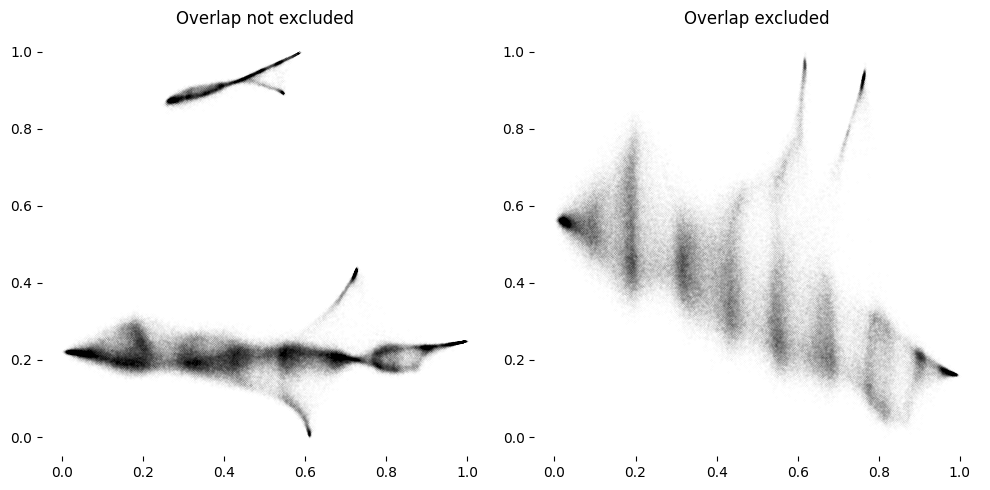

In [43]:
%matplotlib inline 
f, ax = plt.subplots(1,2,figsize=(10,5))
sns.despine(left=True, bottom=True, right=True)
ax[0].set_facecolor((1, 1, 1)) 
ax[0].scatter(embeddings[0][:,0],embeddings[0][:,1], s=0.0001,c='k') 
ax[0].set_title('Overlap not excluded')


ax[1].set_facecolor((1, 1, 1)) 
ax[1].scatter(embeddings[1][:,0],embeddings[1][:,1], s=0.0001,c='k') 
ax[1].set_title('Overlap excluded')


f.tight_layout()
#plt.axis('off')
plt.show()

### Select peaks for endmembers from both cases
- According to which embedding is being used, change from embeddings[0] or embeddings[1], also n_sample_train. 

In [47]:
# choose a grid size
Grid = 256
xmin, xmax = np.amin(embeddings[1][:,0]), np.amax(embeddings[1][:,0])
ymin, ymax = np.amin(embeddings[1][:,1]), np.amax(embeddings[1][:,1])
counts, xedges, yedges = np.histogram2d(embeddings[1][:,0], embeddings[1][:,1], bins=Grid)

# initialize local maxima
local_maxi = []

# Widget
out = Output()
def on_button_click(b):
    with out:
        xloc = xloc_slider.value
        yloc = yloc_slider.value
        local_maxi.append((yloc, xloc))
        print(f"yloc: {yloc}, xloc: {xloc}, count: {str(counts[yloc][xloc])}")

def on_output_button_click(b):
    with out:
        print("local_maxi:", local_maxi)

def manual_peaks(xloc, yloc, width): 
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    sns.despine(left=True, bottom=True, right=True)

    # 2D histogram density plot
    ax[0].set_title(str(counts[yloc][xloc]), size=10)
    ax[0].imshow(counts, cmap='jet',vmin=counts.min(),vmax=counts.max())
    ax[0].plot(xloc, yloc, 'wo', markersize=10)

    # the zoom
    # Define the bounds for the zoom window ensuring they are within valid array indices
    y_start = max(0, yloc - width)
    y_end = min(counts.shape[0], yloc + width)
    x_start = max(0, xloc - width)
    x_end = min(counts.shape[1], xloc + width)

    # Calculate the offset for the marker within the zoomed window
    y_offset = yloc - y_start
    x_offset = xloc - x_start

    # the zoom
    zoom_counts = counts[y_start:y_end, x_start:x_end]
    ax[1].imshow(zoom_counts, cmap='jet')
    ax[1].plot(x_offset, y_offset, 'wo', markersize=10)  # plot at the correct location within the zoomed area
    ax[1].set_title(str(counts[yloc][xloc]), size=10)
    
    # haadf
    ax[2].imshow(haadf,cmap='gray')
    ax[2].set_title('use as reference')
    ax[2].set_aspect('equal')

    F,_ = get_points([(yloc, xloc)],Grid,embeddings=embeddings[1])
    yy = n_sample_train_exclude[F[0]] 
    xx = np.arange(1024**2).reshape((1024,1024))
    zz = [np.where(xx==j) for j in yy]
    k = [ii[0] for ii in zz]
    kk = [ii[1] for ii in zz]
    ax[2].scatter(kk,k,s=10,facecolor='none', edgecolor='r')

    
    
# Create sliders
xloc_slider = widgets.IntSlider(value=int(Grid/2), min=0, max=Grid, step=1)
yloc_slider = widgets.IntSlider(value=int(Grid/2), min=0, max=Grid, step=1)
width_slider = widgets.IntSlider(value=50, min=1, max=100, step=1, description='Zoom')

# Create buttons
print_button = Button(description='Save current peak')
print_button.on_click(on_button_click)

output_button = Button(description='Save and exit')
output_button.on_click(on_output_button_click)

# Display widgets and output
interact(manual_peaks, yloc=yloc_slider, xloc=xloc_slider, width=width_slider)
widgets.HBox([print_button, output_button, out])

interactive(children=(IntSlider(value=128, description='xloc', max=256), IntSlider(value=128, description='ylo…

### Pre-selected peaks for convenience (colors are matched with figure 3)

-  overlap not excluded
-  local_maxi: [(4, 56), (252, 63), (185, 111), (155, 2), (67, 223), (139, 228), (125, 243)]  [black*,cyan*,green,red*, other, other,other]

-  overlap excluded:
-  local_maxi: [(4, 143), (252, 42), (194, 237), (157, 245)]  [black*,cyan*,green,red*]

### Run after selecting peaks

In [100]:
# overlap not excluded
local_maxi= [(4, 56), (252, 63), (185, 111), (155, 2), (67, 223), (139, 228), (125, 243)]
colors = [(0,0,0),(0,1,1),(0,1,0),(1,0,0),(1,165/255,0),(1,165/255,0),(1,165/255,0)]

# overlap excluded
#local_maxi= [(4, 143), (252, 42), (194, 237), (157, 245)]
#colors = [(0,0,0),(0,1,1),(0,1,0),(1,0,0)]


local_max_x = []
local_max_y = []

for i in range(0,len(local_maxi)):
    NewValue_X = (((local_maxi[i][0] ) * (xmax - xmin)) / (Grid - 0)) + xmin
    NewValue_Y = (((local_maxi[i][1] - 0) * (ymax - ymin)) / (Grid - 0)) + ymin
    local_max_x.append(NewValue_X)
    local_max_y.append(NewValue_Y)

x = [x for x in zip(local_max_x,local_max_y)]
nEM = len(x)
print("Number of endmembers selected %03d" % nEM)

Number of endmembers selected 007


### Visualize how the endmembers localize

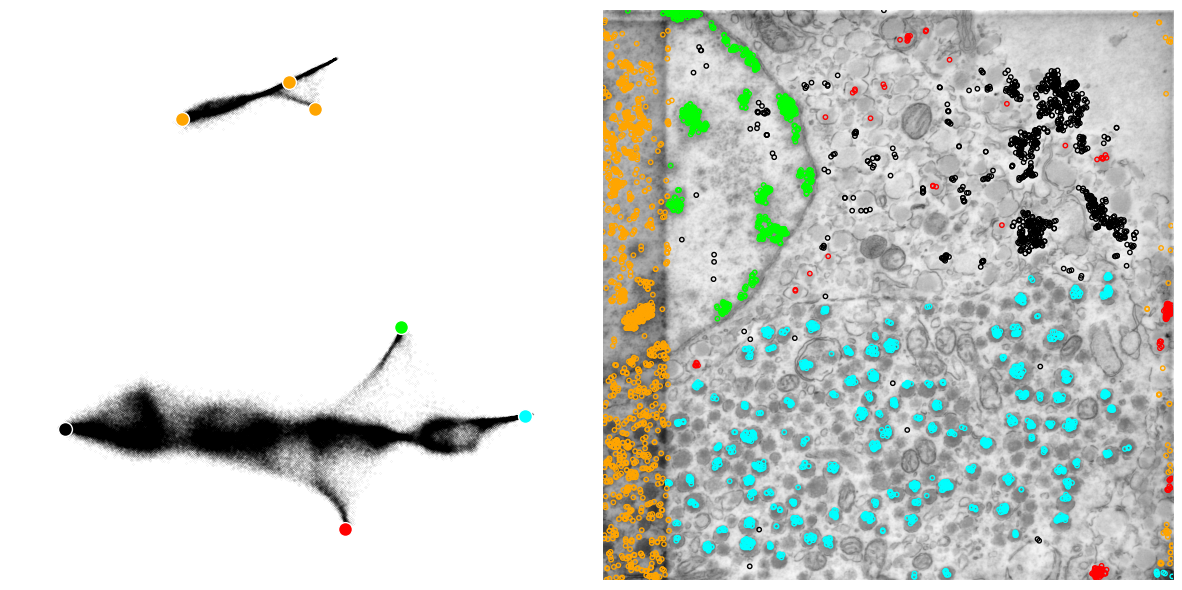

In [101]:
min_max = 1*(1/Grid) # determines bounding box size
points = len(x)
centroid = [] 
F = []           

for i in range(0,points):
    #set bounding square 
    Minx = x[i][0] - min_max
    Maxx = x[i][0] + min_max
    Miny = x[i][1] - min_max
    Maxy = x[i][1] + min_max
    
    #select points
    z3 = [0 if j == 0 else j for j in [j if j <= Maxx else 0 for j in [j if j >= Minx else 0 for j in embeddings[0][:,0]]]]
    zz3 = [0 if j == 0 else j for j in [j if j <= Maxy else 0 for j in [j if j >= Miny else 0 for j in embeddings[0][:,1]]]]
    f = [i for i, e in enumerate([x*y for x,y in zip(z3,zz3)]) if e != 0]
    d = embeddings[0][f]
    F.append(f)
    centroid.append(d)
    
%matplotlib inline 
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.despine(left=True, bottom=True, right=True)

# Scatter plot of the embeddings
ax[0].scatter(embeddings[0][:,0],embeddings[0][:,1],c='k',s=0.001, alpha=1)
ax[0].set_ylim([ymin-0.1, ymax+0.1])
ax[0].set_xlim([xmin-0.1, xmax+0.1])
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
ax[0].set_aspect('equal')
ax[0].set_axis_off()

# Plot pixels used to select endmembers
for i in range(0,len(x)):
    ax[0].scatter(centroid[i].transpose()[0], centroid[i].transpose()[1], color='red', s=0.00001) #, alpha = 0.001)



# Endmember annotation
label = [val for val in list(range(len(x)))]
centroids = np.array(x).transpose()
    
for i, txt in enumerate(label):
    #ax[0].annotate(txt, (centroids[0][i], centroids[1][i]), color=colors[i], size=25)  
    ax[0].scatter(centroids[0][i], centroids[1][i],s=100,facecolor = colors[i],edgecolor='w',marker='o')    

ax[1].imshow(haadf,cmap='gray')
ax[1].set_axis_off()

for i in range(len(x)):
    yy = n_sample_train[F[i]] 
    xx = np.arange(1024**2).reshape((1024,1024))
    zz = [np.where(xx==j) for j in yy]
    k = [ii[0] for ii in zz]
    kk = [ii[1] for ii in zz]
    ax[1].scatter(kk,k,s=10,facecolor='none', edgecolor=colors[i])



# Save each subplot as a separate image
for i, axi in enumerate(ax):
    axi.set_aspect('equal')
    extent = axi.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('/Users/aj/Desktop/CellFigures/raw_material/Figure S1/overlap_%02d.tiff' % i, bbox_inches=extent, format='tiff', dpi=300)
fig.tight_layout()
plt.show()